In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

mpl.rcParams['font.family'] = 'monospace'

In [2]:
from project.utils.geo import get_slice_from_anchor, sel_to_poly_corners
from project.utils.geo_plots import subplots_ortho_dense

In [8]:
mask = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/').fold_mask.load()
mask = mask.where(mask > 0).compute()
mask_cont = mask.where(mask.notnull(), 0).compute()

/Net/Groups/BGI/scratch/bkraft/mamba/envs/dml/lib/python3.10/site-packages/matplotlib/patches.py:2898: RuntimeWarning: divide by zero encountered in double_scalars
  f1 = self.rad / d1
/Net/Groups/BGI/scratch/bkraft/mamba/envs/dml/lib/python3.10/site-packages/matplotlib/patches.py:2902: RuntimeWarning: invalid value encountered in double_scalars
  vertices.extend([(cx + dx1 * f1, cy + dy1 * f1),


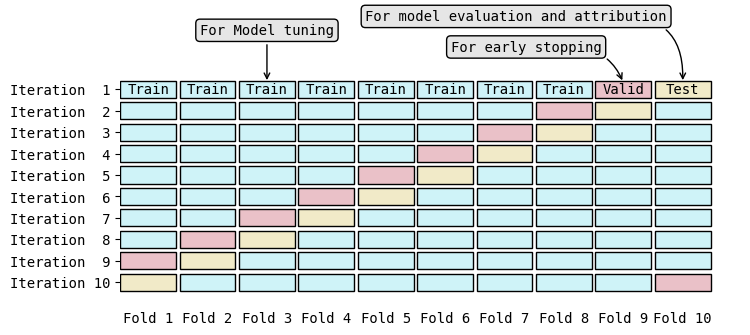

In [53]:
fig, ax = plt.subplots(1, figsize=(8, 3))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

num_folds = 10

for fold in range(num_folds):
    for f in range(num_folds):
        if (fold - 1) % num_folds == f:
            text = 'Valid'
            color = (204/255, 102/255, 119/255)
        elif (fold) % num_folds == f:
            text = 'Test'
            color = (221/255, 204/255, 119/255)
        else:
            text = 'Train'
            color = (136/255, 204/231, 238/255)
        ax.barh([f'Iteration {num_folds-fold:2d}'], [0.94], left=[-0.47 + f], color=(*color, 0.4), edgecolor='k', height=0.8)
        if fold == num_folds - 1:
            ax.text(f, fold, text, ha='center', va='center')
        ax.set_xticks(range(num_folds))
        ax.set_xticklabels([f'Fold {n}' for n in range(1, num_folds + 1)]);

ax.annotate(
    'For Model tuning',
    xy=(2., 9.3), xycoords='data', ha='center',
    xytext=(0, 35), textcoords='offset points',
    bbox=dict(boxstyle='round', fc='0.9'),
    arrowprops=dict(arrowstyle='->',
                    connectionstyle='angle,angleA=0,angleB=90,rad=40'))        

ax.annotate(
    'For early stopping',
    xy=(8., 9.3), xycoords='data', ha='center',
    xytext=(-70, 23), textcoords='offset points',
    bbox=dict(boxstyle='round', fc='0.9'),
    arrowprops=dict(arrowstyle='->',
                    connectionstyle='angle,angleA=0,angleB=110,rad=40'))

ax.annotate(
    'For model evaluation and attribution',
    xy=(9., 9.3), xycoords='data', ha='center',
    xytext=(-120, 45), textcoords='offset points',
    bbox=dict(boxstyle='round', fc='0.9'),
    arrowprops=dict(arrowstyle='->',
                    connectionstyle='angle,angleA=0,angleB=90,rad=60'))

plt.tick_params(bottom=False)

fig.savefig('./cross_val_scheme.png', dpi=300, transparent=True, bbox_inches='tight')

In [22]:
x = np.asanyarray([[3, 2], [1, 0]])
x = np.tile(x, (2, 2))

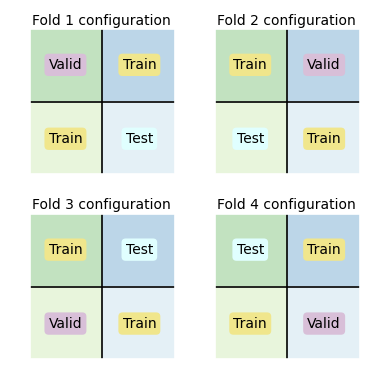

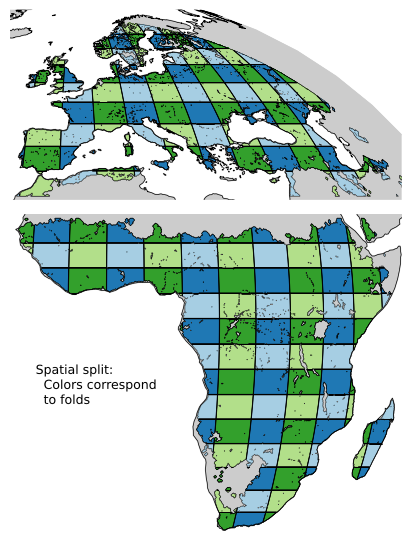

In [5]:
fig, axes = subplots_ortho_dense(text='Spatial split:\n  Colors correspond\n  to folds', add_borders=False)

cm = plt.cm.get_cmap('Paired')
cols = cm(np.linspace(0, 1, cm.N))
cm = ListedColormap(cols[[0, 2, 1, 3]])

mask.plot.imshow(cmap=cm, add_colorbar=False, ax=axes[0], transform=ccrs.PlateCarree())
mask_cont.plot.contour(cmap='k', add_colorbar=False, ax=axes[0], transform=ccrs.PlateCarree(), linewidths=0.2)
mask.plot.contour(cmap='k', add_colorbar=False, ax=axes[0], transform=ccrs.PlateCarree(), linewidths=0.6)
mask.plot(cmap=cm, add_colorbar=False, ax=axes[1], transform=ccrs.PlateCarree())
mask_cont.plot.contour(cmap='k', add_colorbar=False, ax=axes[1], transform=ccrs.PlateCarree(), linewidths=0.2)
mask.plot.contour(cmap='k', add_colorbar=False, ax=axes[1], transform=ccrs.PlateCarree(), linewidths=0.6)

fig.savefig('./cross_val_scheme_dense.png', dpi=300, transparent=True, bbox_inches='tight')

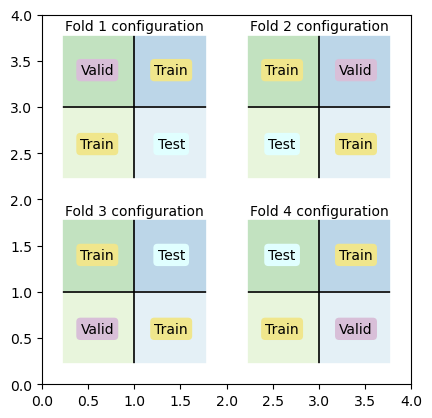

In [148]:
fig, ax = plt.subplots()
ax.imshow(x, cmap=cm, zorder=0, extent=[0, 4, 0, 4], alpha=0.3)
ax.set_aspect('equal')
#ax.axis('off')

for i in np.arange(5):
    if i in [1, 3]:
        lw = 1.2
        c = 'k'
        z = 1
    else:
        lw = 30
        c = 'w'
        z = 2

    ax.axhline(i, color=c, lw=lw, zorder=z)
    ax.axvline(i, color=c, lw=lw, zorder=z)

c = 0
for i, square_i in enumerate([0, 0.5]):
    for j, square_j in enumerate([1, 0.5]):
        ax.text(i * 2 + 0.25, j * 2 + 1.95, f'Fold {[3, 1, 4, 2][c]} configuration', ha='left', va='top')

        center_i = (i * 2) + 1
        center_j= (j * 2) + 1
        offset = 0.4

        text_order = [
            ['Train', 'Test', 'Valid', 'Train'],
            ['Valid', 'Train', 'Train', 'Test'], #
            ['Test', 'Train', 'Train', 'Valid'],
            ['Train', 'Valid', 'Test', 'Train'],
        ][c]

        bbox = {
            'Train': dict(boxstyle='round', fc='khaki', ec='none'),
            'Valid': dict(boxstyle='round', fc='thistle', ec='none'),
            'Test': dict(boxstyle='round', fc='lightcyan', ec='none'),
        }


        ax.text(center_i - offset, center_j + offset, text_order[0], ha='center', va='center', bbox=bbox[text_order[0]])
        ax.text(center_i + offset, center_j + offset, text_order[1], ha='center', va='center', bbox=bbox[text_order[1]])
        ax.text(center_i - offset, center_j - offset, text_order[2], ha='center', va='center', bbox=bbox[text_order[2]])
        ax.text(center_i + offset, center_j - offset, text_order[3], ha='center', va='center', bbox=bbox[text_order[3]])

        c += 1

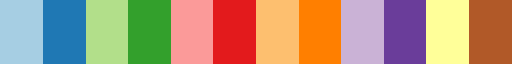

In [179]:
plt.cm.get_cmap('Paired')

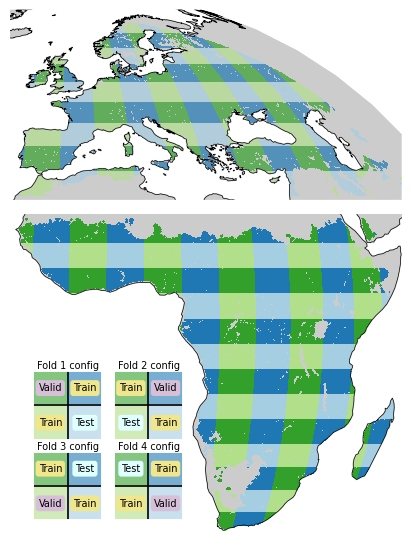

In [191]:
fig, axes = subplots_ortho_dense(add_borders=False)

cm_ = plt.cm.get_cmap('Paired')
cols = cm_(np.linspace(0, 1, cm_.N))
cols2 = cols[[4, 6, 8]]
cm = ListedColormap(cols[[0, 2, 1, 3]])


mask.plot.imshow(cmap=cm, add_colorbar=False, ax=axes[0], transform=ccrs.PlateCarree(), alpha=0.7)
mask_cont.plot.contour(cmap='k', add_colorbar=False, ax=axes[0], transform=ccrs.PlateCarree(), linewidths=0.2)
mask.plot.contour(cmap='k', add_colorbar=False, ax=axes[0], transform=ccrs.PlateCarree(), linewidths=0.6)
mask.plot(cmap=cm, add_colorbar=False, ax=axes[1], transform=ccrs.PlateCarree(), alpha=0.7)
mask_cont.plot.contour(cmap='k', add_colorbar=False, ax=axes[1], transform=ccrs.PlateCarree(), linewidths=0.2)
mask.plot.contour(cmap='k', add_colorbar=False, ax=axes[1], transform=ccrs.PlateCarree(), linewidths=0.6)

axh = axes[1].inset_axes([0.0, 0.03, 0.5, 0.5])

axh.imshow(x, cmap=cm, zorder=0, extent=[0, 4, 0, 4], alpha=0.6)
axh.set_aspect('equal')
axh.axis('off')

for i in np.arange(5):
    if i in [1, 3]:
        lw = 1.2
        c = 'k'
        z = 1
    else:
        lw = 10
        c = 'w'
        z = 2

    axh.axhline(i, color=c, lw=lw, zorder=z)
    axh.axvline(i, color=c, lw=lw, zorder=z)

c = 0
fs = 7

for i, square_i in enumerate([0, 0.55]):
    for j, square_j in enumerate([1, 0.55]):
        axh.text(i * 2 + 0.25, j * 2 + 2.1, f'Fold {[3, 1, 4, 2][c]} config', ha='left', va='top', fontsize=fs)

        center_i = (i * 2) + 1
        center_j= (j * 2) + 1
        offset = 0.43

        text_order = [
            ['Train', 'Test', 'Valid', 'Train'],
            ['Valid', 'Train', 'Train', 'Test'],
            ['Test', 'Train', 'Train', 'Valid'],
            ['Train', 'Valid', 'Test', 'Train'],
        ][c]



        bbox = {
            'Train': dict(boxstyle='round', fc='khaki', ec='none'),
            'Valid': dict(boxstyle='round', fc='thistle', ec='none'),
            'Test': dict(boxstyle='round', fc='lightcyan', ec='none'),
        }

        axh.text(center_i - offset, center_j + offset, text_order[0], ha='center', va='center', bbox=bbox[text_order[0]], fontsize=fs)
        axh.text(center_i + offset, center_j + offset, text_order[1], ha='center', va='center', bbox=bbox[text_order[1]], fontsize=fs)
        axh.text(center_i - offset, center_j - offset, text_order[2], ha='center', va='center', bbox=bbox[text_order[2]], fontsize=fs)
        axh.text(center_i + offset, center_j - offset, text_order[3], ha='center', va='center', bbox=bbox[text_order[3]], fontsize=fs)

        c += 1

fig.savefig('./cross_val_scheme_dense.png', dpi=300, transparent=True, bbox_inches='tight')